In [2]:
import ee
import folium
import geehydro
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [3]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [13]:
def air_info_collection(lat, lng, date_start, date_stop, square):

    """
    Obtain NO2 values for square around given location starting
    mid 2018 and reaching to mid 2022. An inner sqaure shows the 
    pollution source, while an outer one is used as a reference.

    :param lat: Latitude of the location
    :param lng: Longitude of the location
    :param date_start: Start month/year of image collection
    :param date_end: End month/year of image collection
    :param square: Choice of outer or inner square

    :return float: Sum of pixel values in the square and of
                   all images that are inside the time frame.
    """
    
    if square == "inner":
        shape = ee.Geometry.BBox(lng - 0.15, lat - 0.1, lng + 0.15, lat + 0.1)
    if square == "outer":
        shape = ee.Geometry.BBox(lng - 0.15 * math.sqrt(2), lat - 0.1 * math.sqrt(2
        ), lng + 0.15 * math.sqrt(2), lat + 0.1 * math.sqrt(2))
    
    dataset = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2"
    ).select("tropospheric_NO2_column_number_density"
    ).filterDate(str(date_start) + "-01", str(date_stop) + "-01"
    ).filterBounds(shape)

    def setProperty(image):
        dict = image.reduceRegion(ee.Reducer.sum(), shape)
        return image.set(dict)

    pixel_values = dataset.map(setProperty)
    aggregate_pixel_values = (pixel_values.aggregate_array("tropospheric_NO2_column_number_density"
    ).getInfo())
    sum_pixel_value = np.sum(aggregate_pixel_values)

    return sum_pixel_value

In [19]:
exmpl_dict = [
    {"Name": "BASF", "lat": 49.5142, "lng": 8.4250},
    {"Name": "Thyssen", "lat": 51.4871, "lng": 6.7185},
    {"Name": "MiRO", "lat": 49.0576, "lng": 8.3250},
    {"Name": "Boxberg", "lat": 51.4213, "lng": 14.5802},
    {"Name": "Belchatow", "lat": 51.2669, "lng": 19.3266},
    {"Name": "Baymina", "lat": 39.7769, "lng": 32.4022},
    {"Name": "Formosa", "lat": 23.7829, "lng": 120.1929},
    {"Name": "NTPC", "lat": 24.0273, "lng": 82.7901}
    ]

date_list_1 = [
    "2019-01", "2019-07", "2020-01", "2020-07", 
    "2021-01", "2021-07", "2022-01", "2022-07"
    ]

date_list_2 = [
    "2018-07", "2019-01", "2019-07", "2020-01",
    "2020-07", "2021-01", "2021-07", "2022-01"
    ]

square_list = ["outer", "inner"]

j = 0
for entity in exmpl_dict:

    i = 0
    while i < len(date_list_1) - 1:
        result_1 = air_info_collection(lat=entity["lat"], lng=entity["lng"], 
        date_start=date_list_1[i], date_stop=date_list_1[i + 1], square=square_list[j])
        if i == 0 and j == 0:
            entity["2019_outer_1"] = result_1
        if i == 2 and j == 0:
            entity["2020_outer_1"] = result_1
        if i == 4 and j == 0:
            entity["2021_outer_1"] = result_1
        if i == 6 and j == 0:
            entity["2022_outer_1"] = result_1
        if i == 0 and j == 1:
            entity["2019_inner_1"] = result_1
        if i == 2 and j == 1:
            entity["2020_inner_1"] = result_1
        if i == 4 and j == 1:
            entity["2021_inner_1"] = result_1
        if i == 6 and j == 1:
            entity["2022_inner_1"] = result_1

        result_2 = air_info_collection(lat=entity["lat"], lng=entity["lng"], 
        date_start=date_list_2[i], date_stop=date_list_2[i + 1], square=square_list[j])
        if i == 0 and j == 0:
            entity["2018_outer_2"] = result_2
        if i == 2 and j == 0:
            entity["2019_outer_2"] = result_2
        if i == 4 and j == 0:
            entity["2020_outer_2"] = result_2
        if i == 6 and j == 0:
            entity["2021_outer_2"] = result_2
        if i == 0 and j == 1:
            entity["2018_inner_2"] = result_2
        if i == 2 and j == 1:
            entity["2019_inner_2"] = result_2
        if i == 4 and j == 1:
            entity["2020_inner_2"] = result_2
        if i == 6 and j == 1:
            entity["2021_inner_2"] = result_2

        i += 2
    j += 1

df_res = pd.DataFrame(exmpl_dict)

In [29]:
df_res.head(10)

,Name,lat,lng,2019_outer_1,2018_outer_2,2020_outer_1,2019_outer_2,2021_outer_1,2020_outer_2,2022_outer_1,2021_outer_2,2019_inner_1,2018_inner_2,2020_inner_1,2019_inner_2,2021_inner_1,2020_inner_2,2022_inner_1,2021_inner_2
0,BASF,49.5142,8.4250,11.418237,11.664639,9.987972,9.312267,11.026864,8.455670,12.637179,9.391362,6.158366,6.280809,5.428104,5.118938,6.034274,4.643519,6.828543,5.144370
1,Thyssen,51.4871,6.7185,13.452236,11.870862,14.991018,14.362409,12.776909,13.177866,20.263469,12.761455,7.068032,6.152992,7.980246,7.519768,6.773798,6.957821,10.950740,6.814434
2,MiRO,49.0576,8.3250,9.321812,9.488749,8.682511,7.518217,8.154682,7.064802,11.422608,8.063255,4.835312,4.940074,4.498771,3.940684,4.255451,3.695988,5.983194,4.264377
3,Boxberg,51.4213,14.5802,6.975722,5.880651,5.939486,7.417845,5.425391,6.347462,8.255934,7.060735,3.709322,3.087302,3.070001,3.861244,2.895266,3.329671,4.502701,3.699113
4,Belchatow,51.2669,19.3266,6.605050,7.727512,6.858434,7.418913,4.953835,6.543466,9.003476,7.165752,3.516899,4.169045,3.673006,3.876287,2.567564,3.441414,4.736996,3.804755
5,Baymina,39.7769,32.4022,5.378720,8.743618,5.824838,9.691796,5.426127,13.020828,4.804712,12.626610,2.764567,4.636171,3.062317,4.955660,2.832539,6.768194,2.526059,6.575044
6,Formosa,23.7829,120.1929,5.195137,8.444927,7.065948,7.798007,8.150638,7.209366,5.865488,9.114506,2.583788,4.406129,3.635313,4.079562,4.113786,3.766931,3.008076,4.866350
7,NTPC,24.0273,82.7901,58.124359,43.975417,46.028020,32.351409,51.556463,36.024734,57.807963,40.476248,34.019470,26.280956,27.008511,19.366871,29.822397,21.655945,33.387818,23.677318


In [52]:
df1 = ((df_res['2019_inner_1'].mul(2).sub(df_res['2019_outer_1'])) / df_res['2019_outer_1'].sub(df_res['2019_inner_1'])).to_frame('2019_1')
df2 = ((df_res['2018_inner_2'].mul(2).sub(df_res['2018_outer_2'])) / df_res['2018_outer_2'].sub(df_res['2018_inner_2'])).to_frame('2018_2')
df3 = ((df_res['2020_inner_1'].mul(2).sub(df_res['2020_outer_1'])) / df_res['2020_outer_1'].sub(df_res['2020_inner_1'])).to_frame('2020_1')
df4 = ((df_res['2019_inner_2'].mul(2).sub(df_res['2019_outer_2'])) / df_res['2019_outer_2'].sub(df_res['2019_inner_2'])).to_frame('2019_2')
df5 = ((df_res['2021_inner_1'].mul(2).sub(df_res['2021_outer_1'])) / df_res['2021_outer_1'].sub(df_res['2021_inner_1'])).to_frame('2021_1')
df6 = ((df_res['2020_inner_2'].mul(2).sub(df_res['2020_outer_2'])) / df_res['2020_outer_2'].sub(df_res['2020_inner_2'])).to_frame('2020_2')
df7 = ((df_res['2022_inner_1'].mul(2).sub(df_res['2022_outer_1'])) / df_res['2022_outer_1'].sub(df_res['2022_inner_1'])).to_frame('2022_1')
df8 = ((df_res['2021_inner_2'].mul(2).sub(df_res['2021_outer_2'])) / df_res['2021_outer_2'].sub(df_res['2021_inner_2'])).to_frame('2021_2')

In [55]:
df_first_half = df1.merge(df3,left_index=True, right_index=True
).merge(df5,left_index=True, right_index=True).merge(df7,left_index=True, right_index=True)

df_second_half = df2.merge(df4,left_index=True, right_index=True
).merge(df6,left_index=True, right_index=True).merge(df8,left_index=True, right_index=True)

print(df_first_half.head(10))
print(df_second_half.head(10))

     2019_1    2020_1    2021_1    2022_1
0  0.170821  0.190408  0.208646  0.175585
1  0.107112  0.138283  0.128381  0.175889
2  0.077747  0.075299  0.091356  0.099970
3  0.135599  0.069879  0.144318  0.199686
4  0.138837  0.153065  0.075973  0.110282
5  0.057538  0.108523  0.092131  0.108575
6 -0.010554  0.059662  0.019058  0.052727
7  0.411310  0.420042  0.372150  0.367224
     2018_2    2019_2    2020_2    2021_2
0  0.166606  0.220733  0.218084  0.211297
1  0.076099  0.098957  0.118613  0.145856
2  0.086047  0.101509  0.097118  0.122536
3  0.105233  0.085656  0.103347  0.100395
4  0.171585  0.094185  0.109399  0.132031
5  0.128723  0.046351  0.082455  0.086503
6  0.090951  0.097115  0.094264  0.145521
7  0.485264  0.491533  0.507152  0.409454


In [56]:
pd.plot(df)
ax = plt.gca()
ax.set_ylim([0.0, 0.01])

AttributeError: module 'pandas' has no attribute 'plot'

(0.0075, 0.016)

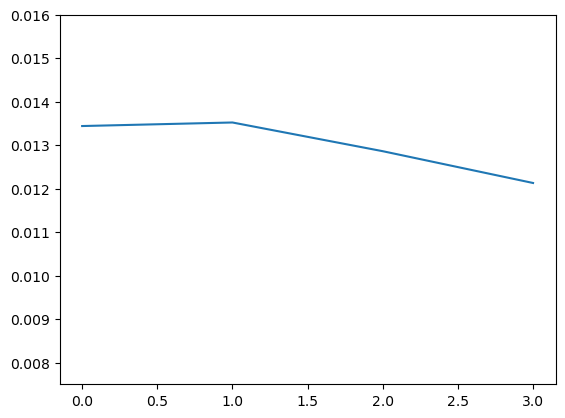

In [275]:
plt.plot(res_list)
ax = plt.gca()
ax.set_ylim([0.0075, 0.016])

In [311]:
lat = 49.514014
lng = 8.421459

coords = [lat, lng]
Map = folium.Map(location=coords, zoom_start=10)

square = ee.Geometry.BBox(lng-0.15, lat-0.1, lng+0.15, lat+0.1)

outer_square = ee.Geometry.BBox(lng-0.15*math.sqrt(2), lat-0.1*math.sqrt(2), lng+0.15*math.sqrt(2), lat+0.1*math.sqrt(2))


dataset = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
dataset = dataset.select('tropospheric_NO2_column_number_density')

date_filter = ee.Filter.date('2019-01-01', '2019-07-01')
dataset = dataset.filter(date_filter)

dataset = dataset.sum().clip(square)

visualisation_params = {
  "min": 0.005,
  "max": 0.015,
  "palette": ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map.addLayer(square)
Map.addLayer(outer_square)
Map.addLayer(dataset, visualisation_params)

folium.Marker(
    location=[lat, lng],
    popup="Coal Power Plant",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(Map)

Map

In [304]:
lat = 23.782990
lng = 120.192958

#lat = 49.514014
#lng = 8.421459

coords = [lat, lng]
Map = folium.Map(location=coords, zoom_start=10)

square = ee.Geometry.BBox(lng-0.15, lat-0.1, lng+0.15, lat+0.1)

outer_square = ee.Geometry.BBox(lng-0.15*math.sqrt(2), lat-0.1*math.sqrt(2), lng+0.15*math.sqrt(2), lat+0.1*math.sqrt(2))


dataset = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
dataset = dataset.select('tropospheric_NO2_column_number_density')

date_filter = ee.Filter.date('2019-11-01', '2021-12-01')
dataset = dataset.filter(date_filter)

dataset = dataset.sum().clip(outer_square)

visualisation_params = {
  "min": 0.01,
  "max": 0.04,
  "palette": ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map.addLayer(square)
Map.addLayer(outer_square)
Map.addLayer(dataset, visualisation_params)

folium.Marker(
    location=[lat, lng],
    popup="Coal Power Plant",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(Map)

Map

In [336]:
lat = 24.027
lng = 82.790
coords = [lat, lng]
Map = folium.Map(location=coords, zoom_start=10)

square = ee.Geometry.BBox(lng-0.15, lat-0.1, lng+0.15, lat+0.1)

outer_square = ee.Geometry.BBox(lng-0.15*math.sqrt(2), lat-0.1*math.sqrt(2), lng+0.15*math.sqrt(2), lat+0.1*math.sqrt(2))


dataset = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
dataset = dataset.select('tropospheric_NO2_column_number_density')

date_filter = ee.Filter.date('2019-01-01', '2020-01-01')
dataset = dataset.filter(date_filter)

dataset = dataset.sum().clip(outer_square)

visualisation_params = {
  "min": 0.02,
  "max": 0.11,
  "palette": ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map.addLayer(square)
Map.addLayer(outer_square)
Map.addLayer(dataset, visualisation_params)

folium.Marker(
    location=[lat, lng],
    popup="Coal Power Plant",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(Map)

Map

In [ ]:
input_ = [
    {"Name": "BASF", "lat": 49.5142, "lng": 8.4250},
    {"Name": "Thyssen", "lat": 51.4871, "lng": 6.7185},
    {"Name": "MiRO", "lat": 49.0576, "lng": 8.3250},
    {"Name": "Boxberg", "lat": 51.4213, "lng": 14.5802},
    {"Name": "Belchatow", "lat": 51.2669, "lng": 19.3266},
    {"Name": "Baymina", "lat": 39.7769, "lng": 32.4022},
    {"Name": "Formosa", "lat": 23.7829, "lng": 120.1929},
    {"Name": "NTPC", "lat": 24.0273, "lng": 82.7901}
    ]

ldate_list = ["2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08",
"2019-09", "2019-10", "2019-11", "2019-12", "2020-01", "2020-02", "2020-03", "2020-04", "2020-05",
"2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12", "2021-01", "2021-02",
"2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11",
"2021-12", "2022-01"]

date_list = ["2019-01", "2020-01", "2021-01", "2022-01"]